# Multidimensional EIP 1559 (work-in-progress)

[Vitalik's recent post](https://ethresear.ch/t/multidimensional-eip-1559/11651) proposes a multidimensional fee mechanism for different types of resources consumed by blockchain transactions. The proposal builds on top of EIP 1559 where the virtual resource that we all know as "gas" is dynamically priced according to local demand-supply inbalances. The main idea is to have more a granular resource (be it real or virtual) definintion a dedicated fee for each type of resource that is dynamically updated according to resource-specific demand-supply imbalance. 

The promise is that this will improve upon the status quo in a number ways: better resource utilization, prices, throughtput, and security. We build a simulation to explore this fee mechanism and evaluate benefits and also costs/risks that have emerged in its discussion.

Results show that the mechanism as proposed in the post (1) is effective in modulating resource prices to optimize multiple resource usage, (2) it can achieve up to 40% gains in both throughtput and total fees while decreasing fees per transaction, and (3) it is robust to shifts in resource distribution.

This is just the beginning of a complete analysis/design, there are many questions that need to be explored. A few directions are using realistic demand and supply data/assumptions, refinining transaction selection logic to make it closer to reality (e.g., adding mempool, smarter builder strategies including optimization), designing and stress testing real resource limits and targets.

# Setup

We model a blockchain system with `n` types of resources. Transactions come with a demand vector, which specifies the required amount of each resource. Blocks have a burst limit and a sustainable target for each resource and resource prices are updated with an EIP-1559-style formula for each resource:

`new_price[i] = price[i] * (1 + ((utilized[i] - target[i]) / target[i]) / 8)`.

We also highlight the following important assumtions:

- There is no gas: so no block gas limit (only resource-specific limits), and no gas basefee (another way to look at it is that the basefee is normalized to 1 gwei and the resource price is the ETH price in gweis of using a unit of that resource).

- Priority fee works by specifying a percentage for each resource type.

- Transactions have a gaslimit that represents the maximum ETH quantity (in gweis) that user is willing to pay.

- Transaction can (optionally) specify a maxfee for each resource.

These follow what was discussed as Option 2 in the forum post.

---

The model builds upon the [original EIP-1559 simulation](https://github.com/ethereum/rig/blob/9de2ecbba130fba13011eca2b229979b0adcba52/eip1559/eip1559.ipynb) from Barnabe Monnot, adding new logic and components.

**Main components and functions**

`Transaction` class

- `gas_limit`: max amount of ETH that the transaction can use.
- `priority_fee`: the tip to the block producers, express in a percentage for each resource.
- `max_fee` (optional): the max price that user is willing to pay, for each resource.
- `res`: resource required to execute transaction, a list with one entry per resource.
    -  Transactions have requirements for unit of resources that they use. For example, EVM execution (s) and transaction calldata (MB). In general, we can specify as a resource any measurable requirement of a transaction.

`update_demand_variable` function: generates demand for transactions.
- This is defined in each simulation as assumptions change.

`include_valid_txs` function: selects transactions, steps (1) filter out invalid txns for which gaslimit is not enough and (2) build block respecting _resource limits_.
- Greedy block building logic where builder sorts by total gas premium and then selects transactions up to resource limit.

`update_price` function: calculate resource prices using EIP-1559-style formula for each resource according do deviation vs sustainable _resource targets_.

In [1]:
import secrets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
constants = {
    # fee mechanism params
    "BLOCK_RESOURCE_LIMITS": [50*1e4, 50*1e4],
    "BLOCK_RESOURCE_TARGETS": [10*1e4, 10*1e4],
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
}

In [3]:
class Transaction:
    def __init__(self, priority_fee, gas_limit, res, max_fee=[]):
        self.tx_hash = secrets.token_bytes(8)
        self.gas_limit = gas_limit
        self.priority_fee = priority_fee
        self.max_fee = max_fee
        self.res = res

    def is_valid(self, price):
        return self.gas_limit >= np.dot(price, self.res)
    
    def get_premium(self, price):
        priority_fee_abs = np.multiply(self.priority_fee, price)
        return np.dot(self.res, priority_fee_abs)


class Block():
    def __init__(self, txs):
        self.txs = txs

In [4]:
def include_valid_txs(params, step, sL, s):
    demand = s["demand"]
    price = s["price"]
    
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if tx.is_valid(price)],
        key = lambda tx: -tx.get_premium(price)
    )
    
    res_limit = constants["BLOCK_RESOURCE_LIMITS"]
    included_transactions = []
    utilized = [0, 0]
    for tx in sorted_valid_demand:
        if utilized[0]<=res_limit[0] and utilized[1]<=res_limit[1]:
            included_transactions.append(tx)
            utilized = np.add(utilized, tx.res)
        else:
            break

    return ({"block": Block(txs=included_transactions)})

In [5]:
def update_price(params, step, sL, s, _input):
    block = _input["block"]
    price = s["price"]
    
    new_price = [0, 0]
    target = constants["BLOCK_RESOURCE_TARGETS"]
    for i in [0, 1]:
        utilized = sum([tx.res[i] for tx in block.txs]) 
        new_price[i] = price[i] * (1 + (utilized - target[i]) / (target[i] * constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]))
    
    return ("price", new_price)

def record_latest_block(params, step, sL, s, _input):
    block = _input["block"]
    return ("latest_block", block)

# Simulations

## Same load on each resource

There is a few parameters that are common to all numerical experiments throughout.

- The tx gaslimit is fixed at 800,000 gweis, this is comparable to a relatively cheap transaction today.

- The block resource limit is 500,000 and the sustainable resource target is 100,000 for both resource 1 and 2. This makes it simpler to show some of the basic dynamics that multidimensional fees introduce. Although the absolute limits are the same, each resource has its own units (eg, compute units and bytes) and there is no gas resource.

The transaction demand for each resource is drawn from a Uniform distribution between 7,500 and 12,500, so the average transaction consumes 10k of resource 1 and 10k of resource 2.

In [6]:
def update_demand_variable(params, step, sL, s, _input):

    demand = {}  
    for i in range(100):
        tx = Transaction(
            res = [uniform(0.75, 1.25)*1e4, uniform(0.75, 1.25)*1e4],
            priority_fee = [0.5, 0.5],
            gas_limit = 8e5
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

In [7]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable
    }
}, {
    "policies": {
        "action": include_valid_txs
    },
    "variables": {
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": [5, 95],
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 300,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)
df = pd.DataFrame(experiment.run())

### Results

Supply and demand of the two resources have the same characteristics, so not surprisingly they have the same "steady state" price. Starting from a situation in which resource 2 is overpriced and resource 1 is underprice, the mechanism gracefully converge to the steady state price.

Number of transactions per block is around a level that is consistent with resource targets (more on this in next experiment).

<AxesSubplot:xlabel='timestep'>

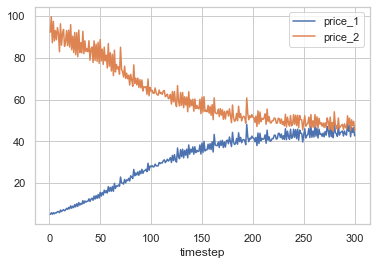

In [8]:
df["price_1"] = df["price"].apply(lambda price: price[0])
df["price_2"] = df["price"].apply(lambda price: price[1])
df['price_1_delta'] = (df['price_1'] - df['price_1'].shift()) / df['price_1'].shift()
df['price_2_delta'] = (df['price_2'] - df['price_2'].shift()) / df['price_2'].shift()
df[df.substep == 2].plot('timestep', ['price_1', 'price_2'])

<AxesSubplot:xlabel='timestep'>

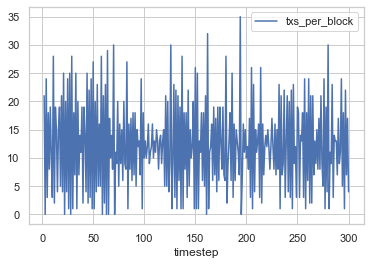

In [9]:
df["txs_per_block"] = df.latest_block.apply(lambda block: len(block.txs))
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "txs_per_block")

## High load on resource 2

Now we increase the load on resource 2, which is now drawn from a Uniform between 9,000 and 14,000, an increase of 15% on consumption of resource 2 per transaction. We start the simulation from the previous steady state price (~45). Everything else is unchanged.

In [29]:
def update_demand_variable(params, step, sL, s, _input):

    demand = {}  
    for i in range(50):
        tx = Transaction(
            res = [uniform(0.75, 1.25)*1e4, uniform(0.9, 1.4)*1e4],
            priority_fee = [0.5, 0.5],
            gas_limit = 8e5
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

In [30]:
%%capture

psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable
    }
}, {
    "policies": {
        "action": include_valid_txs
    },
    "variables": {
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": [1, 1],
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 300,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)

df = pd.DataFrame(experiment.run())

### Results

We start from underpricing both resources and we see that the mechanism immediately corrects. Now the "steady state" price for resource 2 is higher than that of resource 1, since resource 2 is more undersupplied.

Transactions per block start at ~45 in the underpricing situation but very quickly approach the sustainable level of ~10. Similarly for the utilization of both resources that starts at (resource 2) or close to (resource 1) burst level and drops to target level.

<AxesSubplot:xlabel='timestep'>

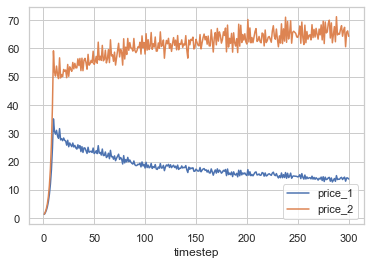

In [31]:
df["price_1"] = df["price"].apply(lambda price: price[0])
df["price_2"] = df["price"].apply(lambda price: price[1])
df[df.substep == 2].plot('timestep', ['price_1', 'price_2'])

<AxesSubplot:xlabel='timestep'>

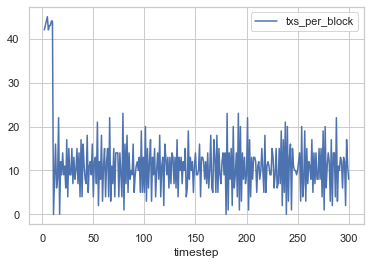

In [32]:
df["txs_per_block"] = df.latest_block.apply(lambda block: len(block.txs))
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "txs_per_block")

<AxesSubplot:xlabel='timestep'>

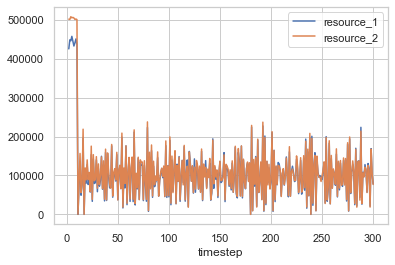

In [33]:
df["resource_1"] = df.latest_block.apply(
    lambda block: sum([tx.res[0] for tx in block.txs])
)
df["resource_2"] = df.latest_block.apply(
    lambda block: sum([tx.res[1] for tx in block.txs])
)
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", ["resource_1", "resource_2"])

In [36]:
df["fee_total"] = df.apply(
    lambda row: row["price_1"] * row["resource_1"] + row["price_2"] * row["resource_2"], axis = 1
)

df["txs_per_block_mavg"] = df["txs_per_block"].rolling(30).mean()
df["resource_1_mavg"] = df["resource_1"].rolling(30).mean()
df["resource_2_mavg"] = df["resource_2"].rolling(30).mean()
df["fee_total_mavg"] = df["fee_total"].rolling(30).mean()
df[["txs_per_block_mavg", "resource_1_mavg", "resource_2_mavg", "fee_total_mavg"]].tail(1)

,txs_per_block_mavg,resource_1_mavg,resource_2_mavg,fee_total_mavg
300,10.633333,102683.829208,102356.816737,8.343116e+06


## High load on resource 2 with uniform price

We now consider the same demand scenario as before, but in this case we can only track and price one resource. This is similar to Ethereum today, whereby resource usage is converted into a virtual resource, gas, according to some pre-defined conversion rates.

For a more clear comparison we assume that conversion is 1:1 for both resources so that the gas requirement of a transaction is simply the sum of the requirement for resource 1 and 2. This is like a gas2.0  which is not the same as current gas because it has different resource "conversion rates", but is a simple benchmark to evaluate effect of multidimensional pricing.

The burst limit for the gas2.0 resource is set to the minimum burst limit (in gas2.0) of resource 1 and resource 2. This is to be robust vs worst case load shifts in which aggregate resource demand shifts completely to one resource. Similar reasoning for the gas2.0 target parameter. 

In [6]:
def update_demand_variable(params, step, sL, s, _input):

    demand = {}  
    for i in range(50):
        tx = Transaction(
            res = [uniform(0.75, 1.25)*1e4 + uniform(0.9, 1.4)*1e4, 0],
            priority_fee = [0.5, 0.5],
            gas_limit = 8e5
        )
        demand[tx.tx_hash] = tx

    return ("demand", demand)

In [7]:
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable
    }
}, {
    "policies": {
        "action": include_valid_txs
    },
    "variables": {
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": [1, 0],
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 300,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)

df = pd.DataFrame(experiment.run())

### Results

Now there is only one price whose "steady state" value is in between price 1 and price 2 in the multidimensional case. This means that in steady state we are underpricing the high load resource 2 and overpricing resource 1. Moreover, the limits and targets on the combined resource are tighter which yield sustained throughtput and total fees that are ~40% lower, and average transaction fees 7.3% higher, than the multidimensional case.

<AxesSubplot:xlabel='timestep'>

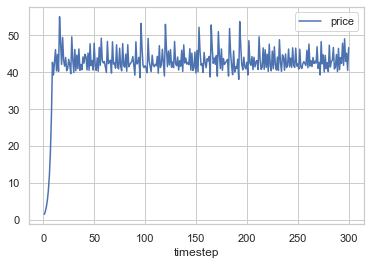

In [8]:
df["price"] = df["price"].apply(lambda price: price[0])
df[df.substep == 2].plot('timestep', ['price'])

<AxesSubplot:xlabel='timestep'>

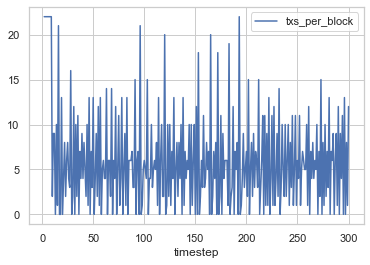

In [9]:
df["txs_per_block"] = df.latest_block.apply(lambda block: len(block.txs))
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "txs_per_block")

<AxesSubplot:xlabel='timestep'>

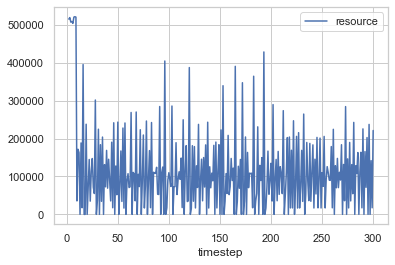

In [10]:
df["resource"] = df.latest_block.apply(
    lambda block: sum([tx.res[0] for tx in block.txs])
)
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", ["resource"])

In [11]:
df["fee_total"] = df.apply(lambda row: row["price"] * row["resource"], axis = 1)

df["txs_per_block_mavg"] = df["txs_per_block"].rolling(30).mean()
df["resource_mavg"] = df["resource"].rolling(30).mean()
df["fee_total_mavg"] = df["fee_total"].rolling(30).mean()
df[["txs_per_block_mavg", "resource_mavg", "fee_total_mavg"]].tail(1)

,txs_per_block_mavg,resource_mavg,fee_total_mavg
300,5.866667,108150.666524,4.906405e+06


## Demand burst on resource 1

Initial exploration of a demand burst on resource 1 above limit. The mechanism seems to respond by adjusting prices and maintaining throughtput. (Needs more detailed analysis with mempool.)

In [22]:
def update_demand_variable_burst(params, step, sL, s, _input):

    demand = {}  
    for i in range(50):
        tx = Transaction(
            res = [uniform(0.75, 1.25)*1e4, uniform(0.9, 1.4)*1e4],
            priority_fee = [0.5, 0.5],
            gas_limit = 8e5
        )
        demand[tx.tx_hash] = tx

    if s["timestep"]>=30 and s["timestep"]<33:
        for i in range(200):
            tx = Transaction(
                res = [3*1e4, 0.9*1e4],
                priority_fee = [0.5, 0.5],
                gas_limit = 20e5
            )
            demand[tx.tx_hash] = tx

    return ("demand", demand)

In [23]:
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable_burst
    }
}, {
    "policies": {
        "action": include_valid_txs
    },
    "variables": {
        "price": update_price,
        "latest_block": record_latest_block,
    }
}]

initial_conditions = {
    "price": [1, 1],
    "demand": {},
    "latest_block": Block(txs=[])
}

simulation_parameters = {
    'T': 300,
    'N': 1,
    'M': {}
}

model = Model(
    initial_state=initial_conditions,
    state_update_blocks=psub,
    params=simulation_parameters
)

simulation = Simulation(
    model=model,
    timesteps=simulation_parameters['T'],
    runs=simulation_parameters['N']
)

experiment = Experiment(simulations=[simulation])
experiment.engine=Engine(backend=Backend.PATHOS, drop_substeps=True)

df = pd.DataFrame(experiment.run())

<AxesSubplot:xlabel='timestep'>

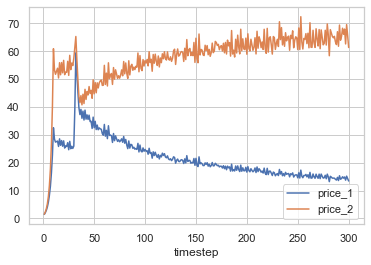

In [24]:
df["price_1"] = df["price"].apply(lambda price: price[0])
df["price_2"] = df["price"].apply(lambda price: price[1])
df[df.substep == 2].plot('timestep', ['price_1', 'price_2'])

<AxesSubplot:xlabel='timestep'>

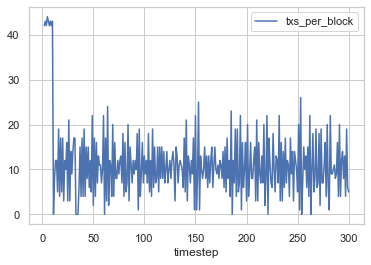

In [25]:
df["txs_per_block"] = df.latest_block.apply(lambda block: len(block.txs))
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", "txs_per_block")

<AxesSubplot:xlabel='timestep'>

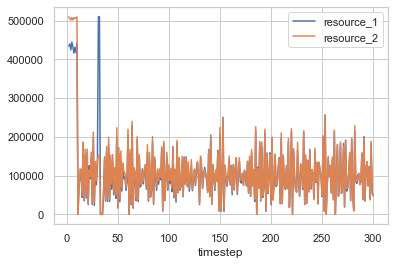

In [26]:
df["resource_1"] = df.latest_block.apply(
    lambda block: sum([tx.res[0] for tx in block.txs])
)
df["resource_2"] = df.latest_block.apply(
    lambda block: sum([tx.res[1] for tx in block.txs])
)
df[(df.timestep > 1) & (df.substep == 2)].plot("timestep", ["resource_1", "resource_2"])